# Aprendizaje Automático
## Tarea 1 - Árboles de Decisión
Este notebook es parte del material generado en el curso de Aprendizaje Automático para la entrega de la Tarea 1.

### Alumnos: Arturo Castagnino, Franco Fontana
### Grupo: 33

### Comentarios:

Desde el presente notebook se van invocando las funciones necesarias para el preprocesamiento de los datos, validaciones cruzadas y comparaciones del algoritmo id3 (implementación desarrollada) con los algoritmos DecisionTreeClassifier y RandomForestClassifier de la librería scikit-learn.
El desarrollo del algoritmo id3 y funciones auxiliares, se encuentran en un script aparte llamado id3.py, el cual es invocado desde este notebook.
Adicionalmente, se cuenta con un archivo de configuración yaml el cual se utiliza para la definición de todos los parámetros necesarios para la ejecución del algoritmo id3 y el estudio de sus variantes

In [1]:
!pip install pandas
!pip install numpy
!pip install scikit-learn
!pip install networkx
!pip install matplotlib
!pip install pyvis
!pip install pyml

### Carga de librerías e inicialización de variables

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn import metrics
from id3 import construir_arbol, predecir
import yaml
import networkx as nx
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold

with open("config.yml", "r") as f:
    config = yaml.safe_load(f)

DATASET_FILE = "./" + config["dataset_file"]
funcionObjetivo = config["funcion_objetivo"]
separador = config["separador"]
random_state = config["random_state"]
test_size = config["test_size"]
n_splits = config["n_splits"]
criterion = config["criterion"]

# Hiperparámetros
min_samples_split = config["min_samples_split"]
min_split_gain = config["min_split_gain"]
min_impurity_decrease = config["min_impurity_decrease"]
n_estimators = config["n_estimators"]
min_impurity_decrease_rand = config["min_impurity_decrease_rand"]

# Hiperparámetros para validación cruzada
min_samples_split_values = config["min_samples_split_values"]
min_split_gain_values = config["min_split_gain_values"]
min_impurity_decrease_values = config["min_impurity_decrease_values"]
min_samples_split_sci = config["min_samples_split_sci"]
min_samples_split_sci_rand = config["min_samples_split_sci_rand"]
n_estimators_values = config["n_estimators_values"]

### Funciones utilizadas

In [3]:
def dicretizeColumns(df, attr):
    # Ajustar y transformar la columna de valores
    df[attr] = discretizer.fit_transform(dataset[[attr]]).astype(int)
    #  Ajustar la escala de 1 a 4
    df[attr] += 1

    return df


def crossValidationManual(dataset, caracteristicas_originales, min_samples_split_values, min_split_gain_values):    # Función para realizar la validación cruzada
    X_train, X_test, y_train, y_test = train_test_split(dataset.drop(funcionObjetivo, axis=1), dataset[funcionObjetivo], test_size=test_size, random_state=random_state)
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    
    best_accuracy = 0
    best_params = None
    
    for min_samples_split in min_samples_split_values:
        for min_split_gain in min_split_gain_values:
            accuracies = []
            cnt = 1
            for train_idx, val_idx in skf.split(X_train, y_train):
                X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
                y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

                arbol = construir_arbol(X_train_fold.join(y_train_fold), caracteristicas_originales, min_samples_split=min_samples_split, min_split_gain=min_split_gain)
                predicciones = predecir(arbol, X_val_fold)
                accuracy = accuracy_score(y_val_fold, predicciones)
                accuracies.append(accuracy)
                print("Split:", cnt, ", min_samples_split:", min_samples_split, ", min_split_gain:", min_split_gain, ", Accuracy:", accuracy)
                cnt += 1
                
            mean_accuracy = np.mean(accuracies)
            print("Promedio accuracy:", mean_accuracy, "\n")
            if mean_accuracy > best_accuracy:
                best_accuracy = mean_accuracy
                best_params = (min_samples_split, min_split_gain)
                
    print(f"Mejores hiperparámetros: min_samples_split={best_params[0]}, min_split_gain={best_params[1]}, Accuracy={best_accuracy}")



def crossValidation_DecisionTreeClassifier(dataset, min_samples_split_values, min_impurity_decrease_values):
    X = dataset.drop(funcionObjetivo, axis=1)
    y = dataset[funcionObjetivo]
    
    best_accuracy = 0
    best_params = None

    # Estrategia de particionamiento
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    for min_samples_split in min_samples_split_values:
        for min_impurity_decrease in min_impurity_decrease_values:
            accuracies = []
            cnt = 1
            for train_index, val_index in skf.split(X, y):
                X_train, X_val = X.iloc[train_index], X.iloc[val_index]
                y_train, y_val = y.iloc[train_index], y.iloc[val_index]

                tree = DecisionTreeClassifier(criterion=criterion, min_samples_split=min_samples_split, min_impurity_decrease=min_impurity_decrease)
                tree.fit(X_train, y_train)
                predictions = tree.predict(X_val)
                accuracies.append(accuracy_score(y_val, predictions))
                print("Split:", cnt, ", min_samples_split:", min_samples_split, ", min_impurity_decrease:", min_impurity_decrease, ", Accuracy:", accuracy_score(y_val, predictions))
                cnt += 1

            mean_accuracy = sum(accuracies) / len(accuracies)
            print("Promedio accuracy:", mean_accuracy, "\n")
            if mean_accuracy > best_accuracy:
                best_accuracy = mean_accuracy
                best_params = (criterion, min_samples_split, min_impurity_decrease)
    
    print(f"Mejores hiperparámetros: min_samples_split={best_params[1]}, min_impurity_decrease={best_params[2]}, Accuracy={best_accuracy}")


def crossValidation_RandomForestClassifier(dataset, min_samples_split_values, min_impurity_decrease_values, n_estimators_values):
    X = dataset.drop(funcionObjetivo, axis=1)
    y = dataset[funcionObjetivo]
    
    # Configurar StratifiedKFold
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    
    best_accuracy = 0
    best_params = None

    for min_samples_split in min_samples_split_values:
        for min_impurity_decrease in min_impurity_decrease_values:
            for n_estimators in n_estimators_values:
                accuracies = []
                cnt = 1
                for train_index, val_index in skf.split(X, y):
                    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
                    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
                    
                    model = RandomForestClassifier(
                        criterion=criterion,
                        min_samples_split=min_samples_split,
                        min_impurity_decrease=min_impurity_decrease,
                        n_estimators=n_estimators,
                        random_state=random_state
                    )
                    
                    model.fit(X_train, y_train)
                    y_pred = model.predict(X_val)
                    accuracies.append(accuracy_score(y_val, y_pred))
                    print("Split:", cnt, ", min_samples_split:", min_samples_split, ", min_impurity_decrease:", min_impurity_decrease, ", n_estimators:", n_estimators, ", Accuracy:", accuracy_score(y_val, y_pred))
                    cnt += 1
                
                mean_accuracy = sum(accuracies) / len(accuracies)
                print("Promedio accuracy:", mean_accuracy, "\n")
                if mean_accuracy > best_accuracy:
                    best_accuracy = mean_accuracy
                    best_params = (criterion, min_samples_split, min_impurity_decrease, n_estimators)

    print(f"Mejores hiperparámetros: min_samples_split={best_params[1]}, min_impurity_decrease={best_params[2]},  n_estimators={best_params[3]}, Accuracy={best_accuracy}")


### Cuerpo principal

### Carga de datos y preprocesamiento

In [4]:
dataset = pd.read_csv(DATASET_FILE, sep=separador)
print(f"{dataset.shape[0]} records read from {DATASET_FILE}\n{dataset.shape[1]} attributes found")

# Consideramos los valores del atributo Target: 'enrolled' y 'graduate' uno solo
dataset[funcionObjetivo] = dataset[funcionObjetivo].replace("Enrolled", "Graduate")

# Discretización de columnas continuas
# Inicializar KBinsDiscretizer con 4 bins y la estrategia 'quantile'
discretizer = KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='quantile')

# Columna Previous qualification (grade)
dataset = dicretizeColumns(dataset, "Previous qualification (grade)")
# Columna Admission grade
dataset = dicretizeColumns(dataset, "Admission grade")
# Columna Curricular units 1st sem (grade)
dataset = dicretizeColumns(dataset, 'Curricular units 1st sem (grade)')
# Columna Curricular units 2nd sem (grade)
dataset = dicretizeColumns(dataset, 'Curricular units 2nd sem (grade)')
# Columna Unemployment rate
dataset = dicretizeColumns(dataset, 'Unemployment rate')
# Columna Inflation rate
dataset = dicretizeColumns(dataset, 'Inflation rate')
# Columna GDP
dataset = dicretizeColumns(dataset, 'GDP')

4424 records read from ./data.csv
37 attributes found


### Separación de los datos en conjuntos de entrenamiento y test
### Obtención de características

In [5]:
# Separamos en conjuntos de entrenamiento y test con proporción 80/20, según yaml de configuración
X = dataset.drop(funcionObjetivo, axis=1)
y = dataset[funcionObjetivo]
if random_state == 0:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y)
else:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)

# Obtenemos las características originales (excluyendo la columna objetivo)
caracteristicas_originales = [col for col in dataset.columns if col != funcionObjetivo]

### Validación cruzada para los parámetros del algoritmo id3 implementado

In [6]:
crossValidationManual(dataset, caracteristicas_originales, min_samples_split_values, min_split_gain_values)

Split: 1 , min_samples_split: 2 , min_split_gain: 0.15 , Accuracy: 0.8135593220338984
Split: 2 , min_samples_split: 2 , min_split_gain: 0.15 , Accuracy: 0.8158192090395481
Split: 3 , min_samples_split: 2 , min_split_gain: 0.15 , Accuracy: 0.8248587570621468
Split: 4 , min_samples_split: 2 , min_split_gain: 0.15 , Accuracy: 0.8122171945701357
Promedio accuracy: 0.8166136206764323 

Split: 1 , min_samples_split: 2 , min_split_gain: 0.2 , Accuracy: 0.8180790960451978
Split: 2 , min_samples_split: 2 , min_split_gain: 0.2 , Accuracy: 0.8248587570621468
Split: 3 , min_samples_split: 2 , min_split_gain: 0.2 , Accuracy: 0.8225988700564971
Split: 4 , min_samples_split: 2 , min_split_gain: 0.2 , Accuracy: 0.8122171945701357
Promedio accuracy: 0.8194384794334943 

Split: 1 , min_samples_split: 2 , min_split_gain: 0.25 , Accuracy: 0.807909604519774
Split: 2 , min_samples_split: 2 , min_split_gain: 0.25 , Accuracy: 0.8259887005649718
Split: 3 , min_samples_split: 2 , min_split_gain: 0.25 , Accuracy

### Entrenamiento del árbol de decisión desarrollado con los mejores parámetros obtenidos en la validación cruzada. Recordar que los parámetros están en el archivo yaml de configuración

In [7]:
arbol = construir_arbol(pd.concat([X_train, y_train], axis=1), caracteristicas_originales, min_samples_split=min_samples_split, min_split_gain=min_split_gain)
print(arbol)

{'Curricular units 2nd sem (approved)': {0: 'Dropout', 1: {'Course': {33: 'Dropout', 8014: 'Dropout', 9003: 'Dropout', 9070: 'Graduate', 9085: 'Dropout', 9119: 'Graduate', 9130: 'Dropout', 9147: 'Dropout', 9238: 'Dropout', 9254: 'Dropout', 9500: 'Dropout', 9556: 'Dropout', 9670: 'Dropout', 9773: 'Dropout', 9853: 'Dropout', 9991: 'Dropout'}}, 2: 'Dropout', 3: 'Graduate', 4: 'Graduate', 5: 'Graduate', 6: 'Graduate', 7: 'Graduate', 8: 'Graduate', 9: {'Age at enrollment': {18: 'Dropout', 19: 'Graduate', 20: 'Graduate', 21: 'Graduate', 22: 'Graduate', 24: 'Graduate', 25: 'Graduate', 28: 'Dropout', 29: 'Graduate', 30: 'Graduate', 33: 'Graduate', 34: 'Graduate', 36: 'Graduate', 37: 'Graduate', 38: 'Dropout', 41: 'Graduate', 44: 'Graduate', 47: 'Graduate', 49: 'Graduate', 57: 'Dropout'}}, 10: {'Curricular units 1st sem (evaluations)': {10: 'Dropout', 11: 'Graduate', 12: 'Graduate', 13: 'Graduate', 14: 'Graduate', 15: 'Graduate', 16: 'Graduate', 17: 'Graduate', 18: 'Graduate', 19: 'Graduate', 2

### Predicción del árbol de decisión desarrollado con el conjunto de test

In [8]:
# Realizamos predicciones con el conjunto de test
predicciones = predecir(arbol, pd.concat([X_test, y_test], axis=1))

print("\nPredicciones para las instancias de test:\n")
print(predicciones)


Predicciones para las instancias de test:

2844    Graduate
374      Dropout
1895    Graduate
2350    Graduate
38      Graduate
          ...   
4341    Graduate
3810    Graduate
379      Dropout
2105     Dropout
2811    Graduate
Length: 885, dtype: object


### Evaluación de los resultados para el árbol desarrollado

Matriz de confusión: 
[[181 103]
 [ 59 542]] 



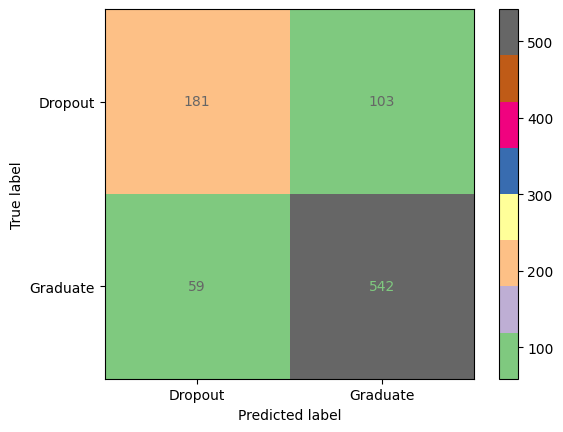


Accuracy: 0.817
              precision    recall  f1-score   support

     Dropout       0.75      0.64      0.69       284
    Graduate       0.84      0.90      0.87       601

    accuracy                           0.82       885
   macro avg       0.80      0.77      0.78       885
weighted avg       0.81      0.82      0.81       885



In [9]:
# Evaluamos el conjunto de test
matrix = confusion_matrix(y_test, predicciones)
print("Matriz de confusión: ")
print(matrix, "\n")
ConfusionMatrixDisplay.from_predictions(y_test, predicciones, cmap='Accent')
plt.show()

print('\nAccuracy: %.3f' % accuracy_score(y_test, predicciones))
print(metrics.classification_report(y_test, predicciones))

### Validación cruzada para los parámetros del algoritmo DecisionTreeClassifier de scikit-learn

In [10]:
crossValidation_DecisionTreeClassifier(dataset, min_samples_split_values, min_impurity_decrease_values)

Split: 1 , min_samples_split: 2 , min_impurity_decrease: 0.15 , Accuracy: 0.8372513562386981
Split: 2 , min_samples_split: 2 , min_impurity_decrease: 0.15 , Accuracy: 0.8435804701627486
Split: 3 , min_samples_split: 2 , min_impurity_decrease: 0.15 , Accuracy: 0.8092224231464737
Split: 4 , min_samples_split: 2 , min_impurity_decrease: 0.15 , Accuracy: 0.8083182640144665
Promedio accuracy: 0.8245931283905968 

Split: 1 , min_samples_split: 2 , min_impurity_decrease: 0.2 , Accuracy: 0.8372513562386981
Split: 2 , min_samples_split: 2 , min_impurity_decrease: 0.2 , Accuracy: 0.8435804701627486
Split: 3 , min_samples_split: 2 , min_impurity_decrease: 0.2 , Accuracy: 0.8092224231464737
Split: 4 , min_samples_split: 2 , min_impurity_decrease: 0.2 , Accuracy: 0.8083182640144665
Promedio accuracy: 0.8245931283905968 

Split: 1 , min_samples_split: 2 , min_impurity_decrease: 0.25 , Accuracy: 0.8372513562386981
Split: 2 , min_samples_split: 2 , min_impurity_decrease: 0.25 , Accuracy: 0.67902350813

### Entrenamiento del árbol de decisión DecisionTreeClassifier de scikit-learn con los mejores parámetros obtenidos en la validación cruzada

In [11]:
# Creando y ajustando el modelo de árbol de decisión
print("\nEntrenamiento del árbol con scikit-learn\n")
# Configuramos los hiperparámetros lo más similar posible al árbol manual
clf = DecisionTreeClassifier(criterion='entropy', min_samples_split=min_samples_split_sci, min_impurity_decrease=min_impurity_decrease) 
clf.fit(X_train, y_train)


Entrenamiento del árbol con scikit-learn



DecisionTreeClassifier(criterion='entropy', min_impurity_decrease=0.15)

### Predicción del árbol de decisión DecisionTreeClassifier de scikit-learn con el conjunto de test

In [12]:
# Haciendo predicciones en el conjunto de prueba
y_pred = clf.predict(X_test)

### Evaluación de los resultados para el árbol de decisión DecisionTreeClassifier de scikit-learn

Matriz de confusión: 
[[213  71]
 [ 89 512]] 



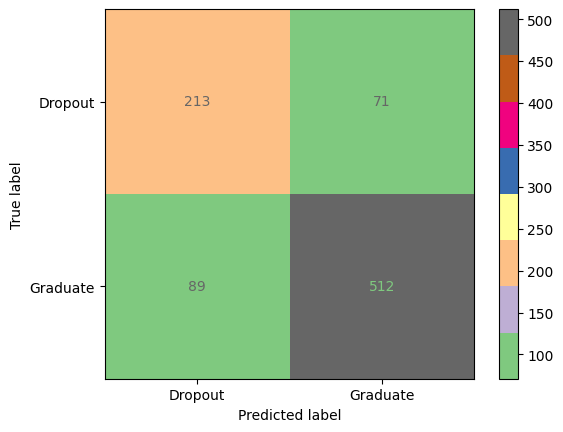

Accuracy: 0.819
              precision    recall  f1-score   support

     Dropout       0.71      0.75      0.73       284
    Graduate       0.88      0.85      0.86       601

    accuracy                           0.82       885
   macro avg       0.79      0.80      0.80       885
weighted avg       0.82      0.82      0.82       885



In [13]:
# Evaluamos nuevamente el conjunto de test obtenido a partir de scikit-learn
matrix = confusion_matrix(y_test, y_pred)
print("Matriz de confusión: ")
print(matrix, "\n")
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Accent')
plt.show()

print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred))

### Validación cruzada para los parámetros del algoritmo RandomForestClassifier de scikit-learn

In [14]:
crossValidation_RandomForestClassifier(dataset, min_samples_split_values, min_impurity_decrease_values, n_estimators_values)

Split: 1 , min_samples_split: 2 , min_impurity_decrease: 0.15 , n_estimators: 10 , Accuracy: 0.6781193490054249
Split: 2 , min_samples_split: 2 , min_impurity_decrease: 0.15 , n_estimators: 10 , Accuracy: 0.6790235081374322
Split: 3 , min_samples_split: 2 , min_impurity_decrease: 0.15 , n_estimators: 10 , Accuracy: 0.7585895117540687
Split: 4 , min_samples_split: 2 , min_impurity_decrease: 0.15 , n_estimators: 10 , Accuracy: 0.6790235081374322
Promedio accuracy: 0.6986889692585895 

Split: 1 , min_samples_split: 2 , min_impurity_decrease: 0.15 , n_estimators: 20 , Accuracy: 0.6781193490054249
Split: 2 , min_samples_split: 2 , min_impurity_decrease: 0.15 , n_estimators: 20 , Accuracy: 0.6790235081374322
Split: 3 , min_samples_split: 2 , min_impurity_decrease: 0.15 , n_estimators: 20 , Accuracy: 0.7585895117540687
Split: 4 , min_samples_split: 2 , min_impurity_decrease: 0.15 , n_estimators: 20 , Accuracy: 0.7739602169981917
Promedio accuracy: 0.7224231464737794 

Split: 1 , min_samples_s

### Entrenamiento del árbol de decisión RandomForestClassifier de scikit-learn con los mejores parámetros obtenidos en la validación cruzada

In [15]:
# Crear el modelo Random Forest
random_forest_classifier = RandomForestClassifier(n_estimators=n_estimators, random_state=random_state, \
                                                  criterion='entropy', min_samples_split=min_samples_split_sci_rand, min_impurity_decrease=min_impurity_decrease_rand)

# Entrenar el modelo con el conjunto de entrenamiento
random_forest_classifier.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', min_impurity_decrease=0.15,
                       n_estimators=50, random_state=1)

### Predicción del árbol de decisión RandomForestClassifier de scikit-learn con el conjunto de test

In [16]:
# Hacer predicciones en el conjunto de prueba
y_pred = random_forest_classifier.predict(X_test)

### Evaluación de los resultados para el árbol de decisión RandomForestClassifier de scikit-learn

Matriz de confusión: 
[[148 136]
 [ 37 564]]


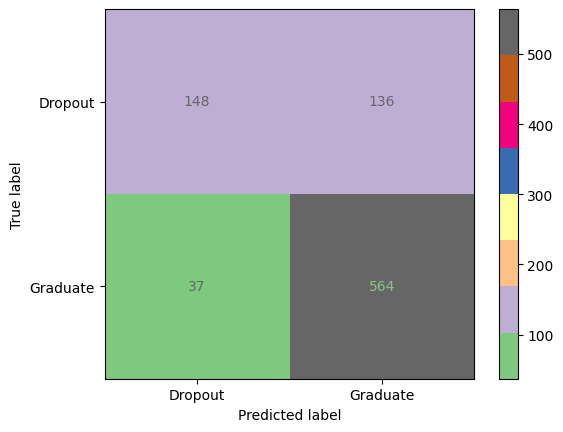

Accuracy: 0.805
              precision    recall  f1-score   support

     Dropout       0.80      0.52      0.63       284
    Graduate       0.81      0.94      0.87       601

    accuracy                           0.80       885
   macro avg       0.80      0.73      0.75       885
weighted avg       0.80      0.80      0.79       885



In [17]:
# Evaluamos nuevamente el conjunto de test obtenido a partir de scikit-learn
matrix = confusion_matrix(y_test, y_pred)
print("Matriz de confusión: ")
print(matrix)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Accent')
plt.show()

# Calcular la precisión
accuracy = accuracy_score(y_test, y_pred)

print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred))